# Data Science Capstone: Clustering of NBA Team Cities and Performance Analysis
In this notebook we cluster the 30 US cities that have NBA teams into groups. We examine team records against cities in each group.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim

## Part 1: Venue data and city clustering
I used Google maps to manually determine the latitude and longitude of basketball arenas, they're recorded here. Note that we will, for the sake of simplicity, associate games by the New Jersey Nets to the location of the arena in Brooklyn.

In [99]:
# Cities and Arena locations
cities = ['Miami', 'Cleveland', 'Sacramento',
       'Portland', 'Orlando', 'Philadelphia',
       'Atlanta', 'Chicago', 'Memphis',
       'Milwaukee', 'Washington', 'Phoenix',
       'Los Angeles', 'Salt Lake City', 'Houston',
       'San Antonio', 'Toronto', 'Dallas',
       'Indianapolis', 'Charlotte',
       'Oklahoma City', 'San Francisco',
       'Detroit', 'Denver', 'Minneapolis',
       'New Orleans', 'New York City', 'Boston',
       'Brooklyn']
latitudes = [25.78163829015947, 41.49678506195122, 38.58045611306761, 45.5320450318535, 28.53998609961617, 
            39.90240015993415, 33.757735095970325, 41.88096239178462, 35.13868576667003, 43.045209756289246, 
            38.89826093085213, 33.44600556643286, 34.04317752166927, 40.768414359865254, 29.751002581697144, 
            29.42726945370561, 43.64373007221918, 32.790597323826205, 39.764158859247864, 35.22540877134052, 
            35.46372180801367, 37.76802875835022, 42.341340505509564, 39.74890746770326, 44.97959990456111, 
            29.949351170719375, 40.7506182881044, 42.36637239447909, 40.6826871594132]
longitudes = [-80.18697407316496, -81.68825581534261, -121.4996602, -122.6669271616183, -81.38376462939495,
             -75.1716392302736, -84.39623856931475, -87.67417590000001, -90.05080097671306, -87.91733530582734,
             -77.02076174132769, -112.07145779205568, -118.2672970153426, -111.9010874, -95.3621434153426,
             -98.43753373505595, -79.3790989, -96.81026214602782, -86.1556225306852, -80.8392607846574,
             -97.51507088465738, -122.38737343068522, -83.05518146931479, -105.00783874602786, -93.2760947,
             -90.08209971534262, -73.99339578465738, -71.06214599999998, -73.97542633065062]

In [100]:
loc_df = pd.DataFrame(list(zip(cities, latitudes, longitudes)), columns=['City', 'Latitude', 'Longitude'])
loc_df.head()

,City,Latitude,Longitude
0,Miami,25.781638,-80.186974
1,Cleveland,41.496785,-81.688256
2,Sacramento,38.580456,-121.499660
3,Portland,45.532045,-122.666927
4,Orlando,28.539986,-81.383765


In [101]:
# foursquare info
CLIENT_ID = '1HSOI055ARYN0FAGG1Y0POLIPU04ZEM1ELOJM2BTU1DU1IRY' # your Foursquare ID
CLIENT_SECRET = 'CN1D45E54UE4OKLG2L1S5CSO10BQKIT3CILDDCFAFUVJ3PRQ' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 200

This function returns venues in the specified radius around specified list of latitudes and longitudes:

In [102]:
# Use this function to return venues
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Arena Latitude', 
                  'Arena Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Below we get venues near each arena and examine the output:

In [103]:
city_venues = getNearbyVenues(names=loc_df['City'], latitudes=loc_df['Latitude'], longitudes=loc_df['Longitude'], radius = 2000)

In [104]:
city_venues.groupby('City').count()

,Arena Latitude,Arena Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Atlanta,100,100,100,100,100,100
Boston,100,100,100,100,100,100
Brooklyn,100,100,100,100,100,100
Charlotte,100,100,100,100,100,100
Chicago,100,100,100,100,100,100
Cleveland,100,100,100,100,100,100
Dallas,100,100,100,100,100,100
Denver,100,100,100,100,100,100
Detroit,100,100,100,100,100,100


In [105]:
city_venues.head()

,City,Arena Latitude,Arena Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Miami,25.781638,-80.186974,American Airlines Arena,25.781307,-80.187889,Basketball Stadium
1,Miami,25.781638,-80.186974,Museum Park,25.784284,-80.186539,Park
2,Miami,25.781638,-80.186974,Victoria's Secret,25.779338,-80.186545,Lingerie Store
3,Miami,25.781638,-80.186974,Dewar's Suite Level @ AA ARENA,25.781443,-80.188981,Basketball Stadium
4,Miami,25.781638,-80.186974,Pérez Art Museum Miami (PAMM),25.785780,-80.186064,Art Museum


Perform onehot encoding to easily record the type of each venue:

In [106]:
# one hot encoding
cities_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,City,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio
0,Miami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Miami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Miami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Miami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Miami,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Group venues by city, then examine the top 5 venues per city:

In [107]:
cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped.head()

,City,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio
0,Atlanta,0.00,0.03,0.0,0.02,0.0,0.01,0.0,0.05,0.00,...,0.0,0.0,0.01,0.0,0.0,0.00,0.01,0.0,0.0,0.00
1,Boston,0.00,0.01,0.0,0.02,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00
2,Brooklyn,0.00,0.01,0.0,0.00,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.01,0.03,0.0,0.0,0.02
3,Charlotte,0.00,0.03,0.0,0.00,0.0,0.00,0.0,0.01,0.01,...,0.0,0.0,0.00,0.0,0.0,0.00,0.01,0.0,0.0,0.00
4,Chicago,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.01,0.01,...,0.0,0.0,0.00,0.0,0.0,0.01,0.02,0.0,0.0,0.03


In [108]:
num_top_venues = 5

for pc in cities_grouped['City']:
    print("----"+pc+"----")
    temp = cities_grouped[cities_grouped['City'] == pc].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Atlanta----
                 venue  freq
0                Hotel  0.06
1          Art Gallery  0.05
2                 Park  0.04
3  American Restaurant  0.03
4              Theater  0.03


----Boston----
                venue  freq
0                Park  0.11
1              Bakery  0.04
2               Hotel  0.04
3  Italian Restaurant  0.04
4       Historic Site  0.04


----Brooklyn----
                venue  freq
0        Cocktail Bar  0.06
1         Coffee Shop  0.05
2       Grocery Store  0.05
3  Italian Restaurant  0.05
4                 Bar  0.04


----Charlotte----
                 venue  freq
0                Hotel  0.08
1                 Park  0.07
2   Italian Restaurant  0.04
3              Theater  0.03
4  American Restaurant  0.03


----Chicago----
            venue  freq
0     Coffee Shop  0.06
1     Pizza Place  0.05
2      Restaurant  0.05
3            Café  0.04
4  Sandwich Place  0.04


----Cleveland----
                 venue  freq
0          Coffee Shop  0.07
1   

Try to determine the optimal k for kmeans clustering. The elbow method does not have a strong indication but we choose k=3, which seems like a reasonable value. We also saw earlier that San Antonio has a relatively low number of venues so we will
remove them as an outlier:

In [112]:
cities_grouped_clustering = cities_grouped[cities_grouped['City'] != 'San Antonio']
cities_grouped_clustering = cities_grouped_clustering.drop('City', 1)

sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(init='k-means++', n_clusters=k, n_init=1000)
    km = km.fit(cities_grouped_clustering.values)
    sum_of_squared_distances.append(km.inertia_)

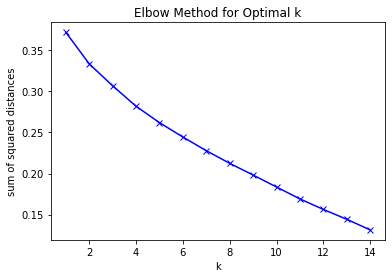

In [113]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [114]:
# Cluster cities into 3 groups:
km = KMeans(init='k-means++', n_clusters=3, n_init=5000)
km = km.fit(cities_grouped_clustering)
labels = km.labels_
labels

array([2, 2, 1, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0,
       1, 2, 2, 1, 1, 2])

Create a dataframe that shows the 10 most common venues for each city:

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlanta,Hotel,Art Gallery,Park,American Restaurant,Theater,Juice Bar,Coffee Shop,Mediterranean Restaurant,Burger Joint,Sandwich Place
1,Boston,Park,Historic Site,Italian Restaurant,Bakery,Hotel,Seafood Restaurant,Gastropub,Mexican Restaurant,Grocery Store,Sandwich Place
2,Brooklyn,Cocktail Bar,Italian Restaurant,Grocery Store,Coffee Shop,Bar,Bookstore,New American Restaurant,Ice Cream Shop,Wine Shop,Pizza Place
3,Charlotte,Hotel,Park,Italian Restaurant,Theater,American Restaurant,Brewery,Deli / Bodega,Performing Arts Venue,Coffee Shop,Pizza Place
4,Chicago,Coffee Shop,Restaurant,Pizza Place,Sandwich Place,Deli / Bodega,Café,Yoga Studio,Brewery,Park,New American Restaurant


In [116]:
# Add the label for each city group determined from KMeans. Again ignoring San Antonio
city_venues_sorted = city_venues_sorted[city_venues_sorted['City'] != 'San Antonio']
city_venues_sorted['Labels'] = labels
city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
0,Atlanta,Hotel,Art Gallery,Park,American Restaurant,Theater,Juice Bar,Coffee Shop,Mediterranean Restaurant,Burger Joint,Sandwich Place,2
1,Boston,Park,Historic Site,Italian Restaurant,Bakery,Hotel,Seafood Restaurant,Gastropub,Mexican Restaurant,Grocery Store,Sandwich Place,2
2,Brooklyn,Cocktail Bar,Italian Restaurant,Grocery Store,Coffee Shop,Bar,Bookstore,New American Restaurant,Ice Cream Shop,Wine Shop,Pizza Place,1
3,Charlotte,Hotel,Park,Italian Restaurant,Theater,American Restaurant,Brewery,Deli / Bodega,Performing Arts Venue,Coffee Shop,Pizza Place,2
4,Chicago,Coffee Shop,Restaurant,Pizza Place,Sandwich Place,Deli / Bodega,Café,Yoga Studio,Brewery,Park,New American Restaurant,1


Group 0: Bars

In [117]:
city_venues_sorted.loc[city_venues_sorted['Labels'] == 0]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
8,Detroit,American Restaurant,Farmers Market,Concert Hall,Lounge,Park,Coffee Shop,Hotel,Diner,Bar,Dessert Shop,0
9,Houston,Hotel,Bar,Vietnamese Restaurant,Cocktail Bar,New American Restaurant,Cajun / Creole Restaurant,Burger Joint,Baseball Stadium,BBQ Joint,Park,0
10,Indianapolis,Bar,Hotel,Steakhouse,Mexican Restaurant,Pizza Place,Brewery,Grocery Store,History Museum,New American Restaurant,Burger Joint,0
11,Los Angeles,Hotel,Coffee Shop,Bar,Burger Joint,Sushi Restaurant,Theater,Gym,Latin American Restaurant,Steakhouse,New American Restaurant,0
12,Memphis,Bar,Park,American Restaurant,Café,Southern / Soul Food Restaurant,Burger Joint,Music Venue,Hotel,Museum,Coffee Shop,0
14,Milwaukee,Bar,Hotel,Steakhouse,Coffee Shop,Pub,Brewery,Theater,Spa,American Restaurant,German Restaurant,0
18,Oklahoma City,American Restaurant,Brewery,Bar,Hotel,Pizza Place,Breakfast Spot,Coffee Shop,Sandwich Place,Pub,Restaurant,0
19,Orlando,American Restaurant,Bar,Hotel,Lounge,Coffee Shop,Brewery,Cocktail Bar,Theater,French Restaurant,Beer Bar,0
21,Phoenix,Coffee Shop,Art Gallery,Lounge,Pizza Place,Bar,Music Venue,Hotel,Mexican Restaurant,Cocktail Bar,Basketball Stadium,0


Group 1: Coffee shops

In [118]:
city_venues_sorted.loc[city_venues_sorted['Labels'] == 1]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
2,Brooklyn,Cocktail Bar,Italian Restaurant,Grocery Store,Coffee Shop,Bar,Bookstore,New American Restaurant,Ice Cream Shop,Wine Shop,Pizza Place,1
4,Chicago,Coffee Shop,Restaurant,Pizza Place,Sandwich Place,Deli / Bodega,Café,Yoga Studio,Brewery,Park,New American Restaurant,1
7,Denver,Brewery,American Restaurant,Hotel,Coffee Shop,Italian Restaurant,Theme Park Ride / Attraction,Park,Pizza Place,Mexican Restaurant,Seafood Restaurant,1
15,Minneapolis,Brewery,Theater,Italian Restaurant,Coffee Shop,Farmers Market,New American Restaurant,Park,Hotel,Scandinavian Restaurant,American Restaurant,1
20,Philadelphia,Sandwich Place,Italian Restaurant,Pizza Place,Lounge,Sports Bar,Food Truck,Baseball Field,Bar,Pharmacy,Park,1
22,Portland,Coffee Shop,Hotel,Brewery,Park,Bookstore,Spa,Bakery,Donut Shop,Sporting Goods Shop,Lounge,1
26,San Francisco,Coffee Shop,Café,Brewery,Park,Art Gallery,Gym / Fitness Center,Gym,Wine Bar,New American Restaurant,Pizza Place,1
27,Toronto,Coffee Shop,Park,Yoga Studio,Gym,Hotel,Art Gallery,Plaza,Italian Restaurant,Café,Liquor Store,1


Group 2: Hotels

In [119]:
city_venues_sorted.loc[city_venues_sorted['Labels'] == 2]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
0,Atlanta,Hotel,Art Gallery,Park,American Restaurant,Theater,Juice Bar,Coffee Shop,Mediterranean Restaurant,Burger Joint,Sandwich Place,2
1,Boston,Park,Historic Site,Italian Restaurant,Bakery,Hotel,Seafood Restaurant,Gastropub,Mexican Restaurant,Grocery Store,Sandwich Place,2
3,Charlotte,Hotel,Park,Italian Restaurant,Theater,American Restaurant,Brewery,Deli / Bodega,Performing Arts Venue,Coffee Shop,Pizza Place,2
5,Cleveland,Hotel,Coffee Shop,Theater,American Restaurant,Steakhouse,Lounge,Italian Restaurant,Park,Brewery,Deli / Bodega,2
6,Dallas,Hotel,Steakhouse,Coffee Shop,Italian Restaurant,American Restaurant,Restaurant,Pizza Place,Plaza,Mexican Restaurant,Cocktail Bar,2
13,Miami,Hotel,American Restaurant,Seafood Restaurant,Nightclub,Café,Park,Coffee Shop,Bar,Peruvian Restaurant,Japanese Restaurant,2
16,New Orleans,Hotel,Cajun / Creole Restaurant,Coffee Shop,Cocktail Bar,Seafood Restaurant,Hotel Bar,American Restaurant,Italian Restaurant,French Restaurant,Sandwich Place,2
17,New York City,Theater,Park,Hotel,Coffee Shop,Boxing Gym,Japanese Restaurant,Art Gallery,Mediterranean Restaurant,American Restaurant,Gym / Fitness Center,2
23,Sacramento,American Restaurant,Coffee Shop,Hotel,Seafood Restaurant,Pizza Place,Park,Dessert Shop,Café,Movie Theater,Sandwich Place,2
24,Salt Lake City,Hotel,Coffee Shop,Mexican Restaurant,Bakery,Park,Brewery,Burger Joint,Theater,Sandwich Place,American Restaurant,2


## Part 2: NBA team records against city clusters and analysis
Here we scrape basketball-reference.com for records from 2010-2019. This first section records records for teams at each location (stored as that location's team).

In [120]:
# First we'll get the full info as before
team_list = ['Miami Heat', 'Cleveland Cavaliers', 'Sacramento Kings',
       'Portland Trail Blazers', 'Orlando Magic', 'Philadelphia 76ers',
       'Atlanta Hawks', 'Chicago Bulls', 'Memphis Grizzlies',
       'Milwaukee Bucks', 'Washington Wizards', 'Phoenix Suns',
       'Los Angeles Clippers', 'Utah Jazz', 'Houston Rockets',
       'San Antonio Spurs', 'Toronto Raptors', 'Dallas Mavericks',
       'Indiana Pacers', 'Los Angeles Lakers', 'Charlotte Hornets',
       'Oklahoma City Thunder', 'Golden State Warriors',
       'Detroit Pistons', 'Denver Nuggets', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'New York Knicks', 'Boston Celtics',
       'Brooklyn Nets', 'New Orleans Hornets', 'New Jersey Nets', 'Charlotte Bobcats']

In [121]:
# define function to return processed table for given month and year
# Returns table of game results for a gien month and year
def get_record_data(month, year):
    url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '_games-' + month + '.html'
    df = pd.read_html(url)[0]
    filt = df[df['Home/Neutral'] != 'Playoffs']
    filt.reset_index(drop=True,inplace=True)
    filt = filt.astype({'PTS': 'int32', 'PTS.1': 'int32'})
    return filt

In [122]:
# define function to update dictionary with wins/losses for filtered data
# This updates a dictionary that has records for a team AT a given location, i.e.,
# win_loss_dict[away_team][location]. It records home records for team in 
# win_loss_dict[team][team]
def update_win_loss_dict(filt, win_loss_dict):
    for row in filt.index.tolist():
        away_team = filt.loc[row, 'Visitor/Neutral']
        home_team = filt.loc[row, 'Home/Neutral']
        if filt.loc[row, 'PTS'] > filt.loc[row, 'PTS.1']:
            win_loss_dict[away_team][home_team]['wins'] += 1
            win_loss_dict[home_team][home_team]['losses'] +=1
        elif filt.loc[row, 'PTS'] < filt.loc[row, 'PTS.1']:
            win_loss_dict[away_team][home_team]['losses'] += 1
            win_loss_dict[home_team][home_team]['wins'] +=1
        elif filt.loc[row, 'PTS'] == filt.loc[row, 'PTS.1']:
            win_loss_dict[away_team][home_team]['ties'] += 1
            win_loss_dict[home_team][home_team]['ties'] +=1
    return win_loss_dict

In [123]:
# create new empty win/loss dict
def create_dict(team_list):
    win_loss_dict = dict()
    for home_team in team_list: # pd.unique(filt['Home/Neutral']):
        win_loss_dict.update({home_team: {}})
        for away_team in team_list: #pd.unique(filt['Home/Neutral']):
            win_loss_dict[home_team].update({away_team: {}})
            win_loss_dict[home_team][away_team]['wins'] = 0
            win_loss_dict[home_team][away_team]['losses'] = 0
            win_loss_dict[home_team][away_team]['ties'] = 0
    return win_loss_dict

In [124]:
# create full dictionary by cycling through years and months
months = ['october', 'november', 'december', 'january', 'february', 'march', 'april', 'may']
win_loss_dict = create_dict(team_list)
for year in range(2010,2020):
    for month in months:
        try: 
            df = get_record_data(month, str(year))
        except:
            continue
        win_loss_dict = update_win_loss_dict(df, win_loss_dict)

In [125]:
win_loss_dict

{'Miami Heat': {'Miami Heat': {'wins': 303, 'losses': 143, 'ties': 0},
  'Cleveland Cavaliers': {'wins': 9, 'losses': 8, 'ties': 0},
  'Sacramento Kings': {'wins': 6, 'losses': 3, 'ties': 0},
  'Portland Trail Blazers': {'wins': 5, 'losses': 5, 'ties': 0},
  'Orlando Magic': {'wins': 12, 'losses': 8, 'ties': 0},
  'Philadelphia 76ers': {'wins': 13, 'losses': 9, 'ties': 0},
  'Atlanta Hawks': {'wins': 11, 'losses': 9, 'ties': 0},
  'Chicago Bulls': {'wins': 13, 'losses': 11, 'ties': 0},
  'Memphis Grizzlies': {'wins': 4, 'losses': 5, 'ties': 0},
  'Milwaukee Bucks': {'wins': 11, 'losses': 9, 'ties': 0},
  'Washington Wizards': {'wins': 12, 'losses': 8, 'ties': 0},
  'Phoenix Suns': {'wins': 8, 'losses': 1, 'ties': 0},
  'Los Angeles Clippers': {'wins': 4, 'losses': 6, 'ties': 0},
  'Utah Jazz': {'wins': 4, 'losses': 6, 'ties': 0},
  'Houston Rockets': {'wins': 4, 'losses': 5, 'ties': 0},
  'San Antonio Spurs': {'wins': 2, 'losses': 7, 'ties': 0},
  'Toronto Raptors': {'wins': 9, 'losses

We consolidate records for New Orleans, Charlotte, and Brooklyn/NJ as their names have changed in the past 10 years:

In [126]:
# Before we make win percentage we should combine bklyn/nj, and different NO and Charlotte teams
win_loss_dict_copy = win_loss_dict.copy()
current_team_list = ['Miami Heat', 'Cleveland Cavaliers', 'Sacramento Kings',
       'Portland Trail Blazers', 'Orlando Magic', 'Philadelphia 76ers',
       'Atlanta Hawks', 'Chicago Bulls', 'Memphis Grizzlies',
       'Milwaukee Bucks', 'Washington Wizards', 'Phoenix Suns',
       'Los Angeles Clippers', 'Utah Jazz', 'Houston Rockets',
       'San Antonio Spurs', 'Toronto Raptors', 'Dallas Mavericks',
       'Indiana Pacers', 'Los Angeles Lakers', 'Charlotte Hornets',
       'Oklahoma City Thunder', 'Golden State Warriors',
       'Detroit Pistons', 'Denver Nuggets', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'New York Knicks', 'Boston Celtics',
       'Brooklyn Nets']
for team in current_team_list:
    # for bk
    win_loss_dict_copy['Brooklyn Nets'][team]['wins'] += win_loss_dict_copy['New Jersey Nets'][team]['wins']
    win_loss_dict_copy['Brooklyn Nets'][team]['losses'] += win_loss_dict_copy['New Jersey Nets'][team]['losses']
    win_loss_dict_copy['Brooklyn Nets'][team]['ties'] += win_loss_dict_copy['New Jersey Nets'][team]['ties']
    win_loss_dict_copy[team]['Brooklyn Nets']['wins'] += win_loss_dict_copy[team]['New Jersey Nets']['wins']
    win_loss_dict_copy[team]['Brooklyn Nets']['losses'] += win_loss_dict_copy[team]['New Jersey Nets']['losses']
    win_loss_dict_copy[team]['Brooklyn Nets']['ties'] += win_loss_dict_copy[team]['New Jersey Nets']['ties']
    del win_loss_dict_copy[team]['New Jersey Nets']
    # for NO
    win_loss_dict_copy['New Orleans Pelicans'][team]['wins'] += win_loss_dict_copy['New Orleans Hornets'][team]['wins']
    win_loss_dict_copy['New Orleans Pelicans'][team]['losses'] += win_loss_dict_copy['New Orleans Hornets'][team]['losses']
    win_loss_dict_copy['New Orleans Pelicans'][team]['ties'] += win_loss_dict_copy['New Orleans Hornets'][team]['ties']
    win_loss_dict_copy[team]['New Orleans Pelicans']['wins'] += win_loss_dict_copy[team]['New Orleans Hornets']['wins']
    win_loss_dict_copy[team]['New Orleans Pelicans']['losses'] += win_loss_dict_copy[team]['New Orleans Hornets']['losses']
    win_loss_dict_copy[team]['New Orleans Pelicans']['ties'] += win_loss_dict_copy[team]['New Orleans Hornets']['ties']
    del win_loss_dict_copy[team]['New Orleans Hornets']
    # for Charlotte
    win_loss_dict_copy['Charlotte Hornets'][team]['wins'] += win_loss_dict_copy['Charlotte Bobcats'][team]['wins']
    win_loss_dict_copy['Charlotte Hornets'][team]['losses'] += win_loss_dict_copy['Charlotte Bobcats'][team]['losses']
    win_loss_dict_copy['Charlotte Hornets'][team]['ties'] += win_loss_dict_copy['Charlotte Bobcats'][team]['ties']
    win_loss_dict_copy[team]['Charlotte Hornets']['wins'] += win_loss_dict_copy[team]['Charlotte Bobcats']['wins']
    win_loss_dict_copy[team]['Charlotte Hornets']['losses'] += win_loss_dict_copy[team]['Charlotte Bobcats']['losses']
    win_loss_dict_copy[team]['Charlotte Hornets']['ties'] += win_loss_dict_copy[team]['Charlotte Bobcats']['ties']
    del win_loss_dict_copy[team]['Charlotte Bobcats']
win_loss_dict_copy['Brooklyn Nets']['Brooklyn Nets']['wins'] += win_loss_dict_copy['New Jersey Nets']['New Jersey Nets']['wins']
win_loss_dict_copy['Brooklyn Nets']['Brooklyn Nets']['losses'] += win_loss_dict_copy['New Jersey Nets']['New Jersey Nets']['losses']
win_loss_dict_copy['Brooklyn Nets']['Brooklyn Nets']['ties'] += win_loss_dict_copy['New Jersey Nets']['New Jersey Nets']['ties']

win_loss_dict_copy['New Orleans Pelicans']['New Orleans Pelicans']['wins'] += win_loss_dict_copy['New Orleans Hornets']['New Orleans Hornets']['wins']
win_loss_dict_copy['New Orleans Pelicans']['New Orleans Pelicans']['losses'] += win_loss_dict_copy['New Orleans Hornets']['New Orleans Hornets']['losses']
win_loss_dict_copy['New Orleans Pelicans']['New Orleans Pelicans']['ties'] += win_loss_dict_copy['New Orleans Hornets']['New Orleans Hornets']['ties']

win_loss_dict_copy['Charlotte Hornets']['Charlotte Hornets']['wins'] += win_loss_dict_copy['Charlotte Bobcats']['Charlotte Bobcats']['wins']
win_loss_dict_copy['Charlotte Hornets']['Charlotte Hornets']['losses'] += win_loss_dict_copy['Charlotte Bobcats']['Charlotte Bobcats']['losses']
win_loss_dict_copy['Charlotte Hornets']['Charlotte Hornets']['ties'] += win_loss_dict_copy['Charlotte Bobcats']['Charlotte Bobcats']['ties']

del win_loss_dict_copy['New Jersey Nets']
del win_loss_dict_copy['New Orleans Hornets']
del win_loss_dict_copy['Charlotte Bobcats']

In [127]:
win_loss_dict_copy

{'Miami Heat': {'Miami Heat': {'wins': 303, 'losses': 143, 'ties': 0},
  'Cleveland Cavaliers': {'wins': 9, 'losses': 8, 'ties': 0},
  'Sacramento Kings': {'wins': 6, 'losses': 3, 'ties': 0},
  'Portland Trail Blazers': {'wins': 5, 'losses': 5, 'ties': 0},
  'Orlando Magic': {'wins': 12, 'losses': 8, 'ties': 0},
  'Philadelphia 76ers': {'wins': 13, 'losses': 9, 'ties': 0},
  'Atlanta Hawks': {'wins': 11, 'losses': 9, 'ties': 0},
  'Chicago Bulls': {'wins': 13, 'losses': 11, 'ties': 0},
  'Memphis Grizzlies': {'wins': 4, 'losses': 5, 'ties': 0},
  'Milwaukee Bucks': {'wins': 11, 'losses': 9, 'ties': 0},
  'Washington Wizards': {'wins': 12, 'losses': 8, 'ties': 0},
  'Phoenix Suns': {'wins': 8, 'losses': 1, 'ties': 0},
  'Los Angeles Clippers': {'wins': 4, 'losses': 6, 'ties': 0},
  'Utah Jazz': {'wins': 4, 'losses': 6, 'ties': 0},
  'Houston Rockets': {'wins': 4, 'losses': 5, 'ties': 0},
  'San Antonio Spurs': {'wins': 2, 'losses': 7, 'ties': 0},
  'Toronto Raptors': {'wins': 9, 'losses

The code below will gather wins/losses/ties based on the city label generated in Part 1.

In [128]:
# Dictionary to associate team name to city name
city_dict = {'Miami Heat': 'Miami', 'Cleveland Cavaliers': 'Cleveland', 'Sacramento Kings': 'Sacramento',
       'Portland Trail Blazers': 'Portland', 'Orlando Magic': 'Orlando', 'Philadelphia 76ers': 'Philadelphia',
       'Atlanta Hawks': 'Atlanta', 'Chicago Bulls': 'Chicago', 'Memphis Grizzlies': 'Memphis',
       'Milwaukee Bucks': 'Milwaukee', 'Washington Wizards': 'Washington', 'Phoenix Suns': 'Phoenix',
       'Los Angeles Clippers': 'Los Angeles', 'Utah Jazz': 'Salt Lake City', 'Houston Rockets': 'Houston',
       'San Antonio Spurs': 'San Antonio', 'Toronto Raptors': 'Toronto', 'Dallas Mavericks': 'Dallas',
       'Indiana Pacers': 'Indianapolis', 'Los Angeles Lakers': 'Los Angeles', 'Charlotte Hornets': 'Charlotte',
       'Oklahoma City Thunder': 'Oklahoma City', 'Golden State Warriors': 'San Francisco',
       'Detroit Pistons': 'Detroit', 'Denver Nuggets': 'Denver', 'Minnesota Timberwolves': 'Minneapolis',
       'New Orleans Pelicans': 'New Orleans', 'New York Knicks': 'New York City', 'Boston Celtics': 'Boston',
       'Brooklyn Nets': 'Brooklyn'}

From here we will not consider the Spurs since we've removed the city as an outlier.

In [151]:
current_team_list = ['Miami Heat', 'Cleveland Cavaliers', 'Sacramento Kings',
       'Portland Trail Blazers', 'Orlando Magic', 'Philadelphia 76ers',
       'Atlanta Hawks', 'Chicago Bulls', 'Memphis Grizzlies',
       'Milwaukee Bucks', 'Washington Wizards', 'Phoenix Suns',
       'Los Angeles Clippers', 'Utah Jazz', 'Houston Rockets',
       'Toronto Raptors', 'Dallas Mavericks',
       'Indiana Pacers', 'Los Angeles Lakers', 'Charlotte Hornets',
       'Oklahoma City Thunder', 'Golden State Warriors',
       'Detroit Pistons', 'Denver Nuggets', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'New York Knicks', 'Boston Celtics',
       'Brooklyn Nets']

In [152]:
# Make empty dictionary for records by label
record_by_city_type = dict()
for team in current_team_list:
    record_by_city_type[team] = dict()
    for num in range(3):
        record_by_city_type[team]['Label ' + str(num)] = dict()
        for result in ['wins', 'losses', 'ties']:
            record_by_city_type[team]['Label ' + str(num)][result] = 0

In [153]:
record_by_city_type

{'Miami Heat': {'Label 0': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 1': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 2': {'wins': 0, 'losses': 0, 'ties': 0}},
 'Cleveland Cavaliers': {'Label 0': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 1': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 2': {'wins': 0, 'losses': 0, 'ties': 0}},
 'Sacramento Kings': {'Label 0': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 1': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 2': {'wins': 0, 'losses': 0, 'ties': 0}},
 'Portland Trail Blazers': {'Label 0': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 1': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 2': {'wins': 0, 'losses': 0, 'ties': 0}},
 'Orlando Magic': {'Label 0': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 1': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 2': {'wins': 0, 'losses': 0, 'ties': 0}},
 'Philadelphia 76ers': {'Label 0': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 1': {'wins': 0, 'losses': 0, 'ties': 0},
  'Label 2': {'wins': 0

In [154]:
# Keep in mind that first index is the team playing, second index is the 'city' where they are playing
# Here we are NOT including home records
for away_team in current_team_list:
    for home_team in current_team_list:
        ### TEST EFFECT OF INCLUDING HOME GAMES
        if home_team != away_team:
            city = city_dict[home_team]
            label = city_venues_sorted.loc[city_venues_sorted['City'] == city, 'Labels'].item()
            for result in ['wins', 'losses', 'ties']:
                record_by_city_type[away_team]['Label ' + str(label)][result] += win_loss_dict_copy[away_team][home_team][result]

Convert win/loss record against city types to a win percentage:

In [155]:
win_perc_dict = dict()
for away_team in current_team_list: # pd.unique(filt['Home/Neutral']):
    win_perc_dict.update({away_team: {}})
    for num in range(3): #pd.unique(filt['Home/Neutral']):
        label = 'Label ' + str(num)
        try:
            win_perc_dict[away_team][label] = record_by_city_type[away_team][label]['wins'] / (\
             record_by_city_type[away_team][label]['wins'] + record_by_city_type[away_team][label]['losses'] \
             + record_by_city_type[away_team][label]['ties'])
        except:
            record_by_city_type[away_team][label] = np.nan
win_perc_dict

{'Miami Heat': {'Label 0': 0.5106382978723404,
  'Label 1': 0.5581395348837209,
  'Label 2': 0.5341614906832298},
 'Cleveland Cavaliers': {'Label 0': 0.4305555555555556,
  'Label 1': 0.4365079365079365,
  'Label 2': 0.4177215189873418},
 'Sacramento Kings': {'Label 0': 0.2953020134228188,
  'Label 1': 0.2743362831858407,
  'Label 2': 0.3008130081300813},
 'Portland Trail Blazers': {'Label 0': 0.4074074074074074,
  'Label 1': 0.42857142857142855,
  'Label 2': 0.4527027027027027},
 'Orlando Magic': {'Label 0': 0.30973451327433627,
  'Label 1': 0.37168141592920356,
  'Label 2': 0.3626373626373626},
 'Philadelphia 76ers': {'Label 0': 0.3230769230769231,
  'Label 1': 0.3619047619047619,
  'Label 2': 0.30337078651685395},
 'Atlanta Hawks': {'Label 0': 0.3918918918918919,
  'Label 1': 0.43478260869565216,
  'Label 2': 0.4578313253012048},
 'Chicago Bulls': {'Label 0': 0.4857142857142857,
  'Label 1': 0.422680412371134,
  'Label 2': 0.46236559139784944},
 'Memphis Grizzlies': {'Label 0': 0.412

Create a dataframe out of the win percentage information. We replace any NaN with means of the column (for 
instance, the Spurs are in their own category so have no record against themselves.)

In [156]:
# Create dataframe of win percentage data
wp_df = pd.DataFrame.from_dict(win_perc_dict, orient='index')

In [157]:
wp_df = wp_df.fillna(wp_df.mean())

In [158]:
wp_df

,Label 0,Label 1,Label 2
Miami Heat,0.510638,0.558140,0.534161
Cleveland Cavaliers,0.430556,0.436508,0.417722
Sacramento Kings,0.295302,0.274336,0.300813
Portland Trail Blazers,0.407407,0.428571,0.452703
Orlando Magic,0.309735,0.371681,0.362637
Philadelphia 76ers,0.323077,0.361905,0.303371
Atlanta Hawks,0.391892,0.434783,0.457831
Chicago Bulls,0.485714,0.422680,0.462366
Memphis Grizzlies,0.412162,0.500000,0.421429
Milwaukee Bucks,0.344828,0.491667,0.366667


Use the elbow method to determine the best k value for clustering

In [159]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(init='k-means++', n_clusters=k, n_init=1000)
    km = km.fit(wp_df.values)
    sum_of_squared_distances.append(km.inertia_)

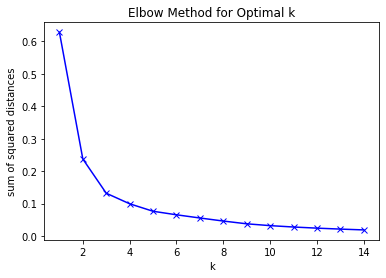

In [160]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

It looks like the elbow is at k=3 so we will use that for our number of clusters:

In [162]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10000)
k_means.fit(wp_df.values)
labels = k_means.labels_
labels

array([2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 2, 2,
       1, 0, 1, 1, 1, 0, 1])

In [163]:
wp_df['Record Labels'] = labels
wp_df.head()

,Label 0,Label 1,Label 2,Record Labels
Miami Heat,0.510638,0.558140,0.534161,2
Cleveland Cavaliers,0.430556,0.436508,0.417722,0
Sacramento Kings,0.295302,0.274336,0.300813,1
Portland Trail Blazers,0.407407,0.428571,0.452703,0
Orlando Magic,0.309735,0.371681,0.362637,1


Examine the groupings by record in terms of their win percentage averages:

In [164]:
wp_df.groupby('Record Labels').mean().mean(axis=1)

Record Labels
0    0.440517
1    0.328722
2    0.541704
dtype: float64

This suggests that we may just be grouping by overall team performance, where Record Label 1 is the
group of worst performing teams and Record Label 2 is the best peforming teams. Let's list them out
to investigate further:

In [165]:
for team in current_team_list:
    wp_df.at[team, 'City Labels'] = int(city_venues_sorted.loc[city_venues_sorted['City'] == city_dict[team], 'Labels'].item())

In [166]:
wp_df.head()

,Label 0,Label 1,Label 2,Record Labels,City Labels
Miami Heat,0.510638,0.558140,0.534161,2,2.0
Cleveland Cavaliers,0.430556,0.436508,0.417722,0,2.0
Sacramento Kings,0.295302,0.274336,0.300813,1,2.0
Portland Trail Blazers,0.407407,0.428571,0.452703,0,1.0
Orlando Magic,0.309735,0.371681,0.362637,1,0.0


Record Label 0, overall win percentage 0.440517

In [167]:
wp_df.loc[wp_df['Record Labels']==0]

,Label 0,Label 1,Label 2,Record Labels,City Labels
Cleveland Cavaliers,0.430556,0.436508,0.417722,0,2.0
Portland Trail Blazers,0.407407,0.428571,0.452703,0,1.0
Atlanta Hawks,0.391892,0.434783,0.457831,0,2.0
Chicago Bulls,0.485714,0.422680,0.462366,0,1.0
Memphis Grizzlies,0.412162,0.500000,0.421429,0,0.0
Milwaukee Bucks,0.344828,0.491667,0.366667,0,0.0
Los Angeles Clippers,0.500000,0.406504,0.524476,0,0.0
Utah Jazz,0.391304,0.446281,0.430894,0,2.0
Toronto Raptors,0.489362,0.465347,0.437158,0,1.0
Dallas Mavericks,0.440994,0.424779,0.516129,0,2.0


Record Label 1, overall win percentage 0.328722

In [168]:
wp_df.loc[wp_df['Record Labels']==1]

,Label 0,Label 1,Label 2,Record Labels,City Labels
Sacramento Kings,0.295302,0.274336,0.300813,1,2.0
Orlando Magic,0.309735,0.371681,0.362637,1,0.0
Philadelphia 76ers,0.323077,0.361905,0.303371,1,1.0
Washington Wizards,0.343284,0.398305,0.329193,1,2.0
Phoenix Suns,0.311111,0.360360,0.381944,1,0.0
Los Angeles Lakers,0.292857,0.403509,0.402685,1,0.0
Charlotte Hornets,0.333333,0.339806,0.282895,1,2.0
Detroit Pistons,0.252101,0.309735,0.345455,1,0.0
Minnesota Timberwolves,0.261438,0.252632,0.330935,1,1.0
New Orleans Pelicans,0.359477,0.330435,0.367521,1,2.0


Record Label 2, overall win percentage 0.541704

In [169]:
wp_df.loc[wp_df['Record Labels']==2]

,Label 0,Label 1,Label 2,Record Labels,City Labels
Miami Heat,0.510638,0.558140,0.534161,2,2.0
Houston Rockets,0.463768,0.503937,0.567568,2,0.0
Oklahoma City Thunder,0.500000,0.540323,0.596026,2,0.0
Golden State Warriors,0.480000,0.576923,0.668966,2,1.0


As suspected, this appears to cluster based on overall performance over the last 10 years without strong correlation
or alignment between record labels and city labels. However, it may be more valuable to analyze an a more individual basis where teams tend to perform better.

In [183]:
wp_df_raw = pd.DataFrame.from_dict(win_perc_dict, orient='index')

Teams that perform best at "Bar" cities:

In [197]:
wp_df[wp_df_raw.idxmax(axis=1) == 'Label 0']

,Label 0,Label 1,Label 2,Record Labels,City Labels
Chicago Bulls,0.485714,0.422680,0.462366,0,1.0
Toronto Raptors,0.489362,0.465347,0.437158,0,1.0
Indiana Pacers,0.478261,0.361345,0.410256,0,0.0


Teams that perform best at "Coffee" cities:

In [198]:
wp_df[wp_df_raw.idxmax(axis=1) == 'Label 1']

,Label 0,Label 1,Label 2,Record Labels,City Labels
Miami Heat,0.510638,0.558140,0.534161,2,2.0
Cleveland Cavaliers,0.430556,0.436508,0.417722,0,2.0
Orlando Magic,0.309735,0.371681,0.362637,1,0.0
Philadelphia 76ers,0.323077,0.361905,0.303371,1,1.0
Memphis Grizzlies,0.412162,0.500000,0.421429,0,0.0
Milwaukee Bucks,0.344828,0.491667,0.366667,0,0.0
Washington Wizards,0.343284,0.398305,0.329193,1,2.0
Utah Jazz,0.391304,0.446281,0.430894,0,2.0
Los Angeles Lakers,0.292857,0.403509,0.402685,1,0.0
Charlotte Hornets,0.333333,0.339806,0.282895,1,2.0


Teams that peform best at "Hotel" cities:

In [199]:
wp_df[wp_df_raw.idxmax(axis=1) == 'Label 2']

,Label 0,Label 1,Label 2,Record Labels,City Labels
Sacramento Kings,0.295302,0.274336,0.300813,1,2.0
Portland Trail Blazers,0.407407,0.428571,0.452703,0,1.0
Atlanta Hawks,0.391892,0.434783,0.457831,0,2.0
Phoenix Suns,0.311111,0.360360,0.381944,1,0.0
Los Angeles Clippers,0.500000,0.406504,0.524476,0,0.0
Houston Rockets,0.463768,0.503937,0.567568,2,0.0
Dallas Mavericks,0.440994,0.424779,0.516129,0,2.0
Oklahoma City Thunder,0.500000,0.540323,0.596026,2,0.0
Golden State Warriors,0.480000,0.576923,0.668966,2,1.0
Detroit Pistons,0.252101,0.309735,0.345455,1,0.0


Teams that perform worst at "Bar" cities:

In [200]:
wp_df[wp_df_raw.idxmin(axis=1) == 'Label 0']

,Label 0,Label 1,Label 2,Record Labels,City Labels
Miami Heat,0.510638,0.558140,0.534161,2,2.0
Portland Trail Blazers,0.407407,0.428571,0.452703,0,1.0
Orlando Magic,0.309735,0.371681,0.362637,1,0.0
Atlanta Hawks,0.391892,0.434783,0.457831,0,2.0
Memphis Grizzlies,0.412162,0.500000,0.421429,0,0.0
Milwaukee Bucks,0.344828,0.491667,0.366667,0,0.0
Phoenix Suns,0.311111,0.360360,0.381944,1,0.0
Utah Jazz,0.391304,0.446281,0.430894,0,2.0
Houston Rockets,0.463768,0.503937,0.567568,2,0.0
Los Angeles Lakers,0.292857,0.403509,0.402685,1,0.0


Teams that perform worst at "Coffee" cities:

In [201]:
wp_df[wp_df_raw.idxmin(axis=1) == 'Label 1']

,Label 0,Label 1,Label 2,Record Labels,City Labels
Sacramento Kings,0.295302,0.274336,0.300813,1,2.0
Chicago Bulls,0.485714,0.422680,0.462366,0,1.0
Los Angeles Clippers,0.500000,0.406504,0.524476,0,0.0
Dallas Mavericks,0.440994,0.424779,0.516129,0,2.0
Indiana Pacers,0.478261,0.361345,0.410256,0,0.0
Minnesota Timberwolves,0.261438,0.252632,0.330935,1,1.0
New Orleans Pelicans,0.359477,0.330435,0.367521,1,2.0
Boston Celtics,0.477941,0.472000,0.494505,0,2.0
Brooklyn Nets,0.307087,0.299065,0.329341,1,1.0


Teams that perform worst at "Hotel" cities:

In [202]:
wp_df[wp_df_raw.idxmin(axis=1) == 'Label 2']

,Label 0,Label 1,Label 2,Record Labels,City Labels
Cleveland Cavaliers,0.430556,0.436508,0.417722,0,2.0
Philadelphia 76ers,0.323077,0.361905,0.303371,1,1.0
Washington Wizards,0.343284,0.398305,0.329193,1,2.0
Toronto Raptors,0.489362,0.465347,0.437158,0,1.0
Charlotte Hornets,0.333333,0.339806,0.282895,1,2.0
Denver Nuggets,0.410256,0.436893,0.400000,0,1.0
